# A/B Testing Course

## Lesson 8. Stratification

### Homework

#### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime

In [3]:
from scipy.stats import ttest_ind

#### Import Data

In [4]:
df = pd.read_csv('stratification_task_data_public.csv')

#### Data Description

df:
- x1, ..., x10 - stratification features
- y - metric value

#### Checking Data

In [5]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.869,30,33.8,0,1,0.2,1992,1,1,1,1903
1,0.759,27,21.7,2,0,3.5,1995,1,1,2,1313
2,0.456,29,37.6,2,0,3.1,1993,0,0,0,1484
3,0.060,35,27.5,2,0,4.7,1988,0,0,1,1188
4,0.939,19,30.7,0,0,3.6,2003,1,1,2,842


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  int64  
 2   x3      10000 non-null  float64
 3   x4      10000 non-null  int64  
 4   x5      10000 non-null  int64  
 5   x6      10000 non-null  float64
 6   x7      10000 non-null  int64  
 7   x8      10000 non-null  int64  
 8   x9      10000 non-null  int64  
 9   x10     10000 non-null  int64  
 10  y       10000 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 859.5 KB


#### Task 1. 

Let's assume we have a set of features that are calculated independently of the experiment. Using these features, we need to divide the objects into strata so that the variance of the stratified mean is minimized and the proportion of each stratum is at least 5% of all data.
Implement a function to divide objects into strata.

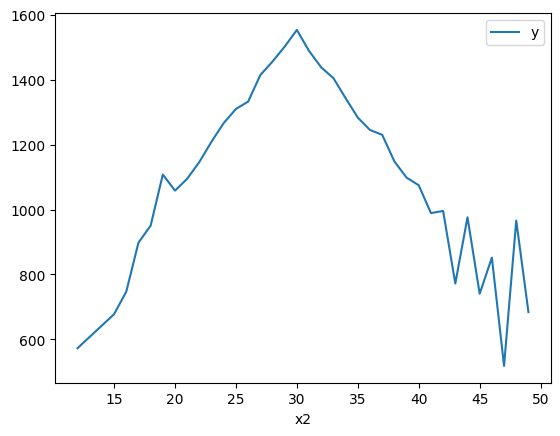

In [7]:
# grouping by x2 feature and calculating metrics means
df.groupby('x2', as_index=False).agg({'y':'mean'}).plot(x='x2', y='y');

In [8]:
# spliting x2 feature values into categories
df['category'] = pd.cut(df.x2, bins=[11, 23, 26, 31, 33, 36, 50], labels=['1', '2', '3', '4', '5', '6'])

In [9]:
# checking that none of the categories is less tha 5% size
df.category.value_counts(normalize=True)

3    0.4112
2    0.1490
4    0.1447
5    0.1358
6    0.0825
1    0.0768
Name: category, dtype: float64

<AxesSubplot:xlabel='category'>

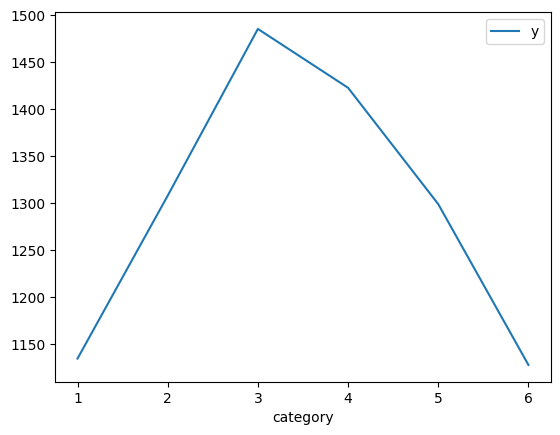

In [10]:
# # grouping by category feature and calculating metrics means
df.groupby('category', as_index=False).agg({'y':'mean'}).plot(x='category', y='y')

In [11]:
# implementing our categroies for stratification
def get_strats(df: pd.DataFrame):
    """Returns strats for our data.
    
    :return (list | np.array | pd.Series): list of starts.
    """
    # YOUR_CODE_HERE
    df['category'] = pd.cut(df.x2, 
                            bins=[11, 23, 26, 31, 33, 36, 50],
                            labels=['1', '2', '3', '4', '5', '6'])
    return df.category.to_list()


def calculate_strat_var(df):
    """Calculating stratified variation of the population."""
    strat_vars = df.groupby('strat')['y'].var()
    weights = df['strat'].value_counts(normalize=True)
    stratified_var = (strat_vars * weights).sum()
    return stratified_var


if __name__ == "__main__":
    bound = 50000
    df = pd.read_csv('stratification_task_data_public.csv')
    strats = get_strats(df.drop('y', axis=1))
    assert len(strats) == len(df), "Wrong size of strats list"
    min_part = pd.Series(strats).value_counts(normalize=True).min()
    assert min_part >= 0.05, "Minimal size of a strata is less than 5%"
    df['strat'] = strats
    strat_var = calculate_strat_var(df)
    err_msg = f"Variance equal to {strat_var:0.1f}, and we have to lower it below {bound}"
    assert strat_var <= bound, err_msg
    print(f'Perfect! Variance equal to {strat_var:0.1f}, that is less than our boundary {bound}')

Perfect! Variance equal to 49850.9, that is less than our boundary 50000


#### Task 2. 

You need to write a function that will stratify the clients and distribute them among groups.

We will consider the distribution among groups to be stratified if the number of clients in each stratum differs by no more than 1.

Implement the function `split_stratified`.

In [12]:
import numpy as np
import pandas as pd


def split_stratified(strats: np.array) -> np.array:
    """Распределяет объекты по группам (контрольная и экспериментальная).
    
    :param strats: массив с разбиением на страты.
    :return: массив из 0 и 1, 0 - контрольная группа, 1 - экспериментальная.
    """
    # YOUR_CODE_HERE
    strats_u = set(strats.tolist())
    vals = strats.tolist()

    dct = dict()
    for strat in strats_u:
        dct[strat] = list()
        for i in range(len(vals)):
            if vals[i] == strat:
                dct[strat].append(i)

    groups = [False] * len(vals)
    for k in dct:
        lst = dct[k]
        np.random.shuffle(lst)
        mid = len(lst) // 2
        a = dct[k][:mid]
        b = dct[k][mid:]
        for idx in a:
            groups[idx] = 0
        for idx in b:
            groups[idx] = 1
    
    return groups
    

def check_split(df: pd.DataFrame):
    """Проверяет корректность разбиения на страты.
    
    :param df: датафрейм с двумя столбцами: ['strat', 'group'].
    """
    df_agg = (
        df
        .groupby(['strat', 'group'])[['group']].count()
        .rename(columns={'group': 'count'})
        .reset_index()
    )
    df_pivot = df_agg.pivot(index='strat', values='count', columns='group')
    max_delta = (df_pivot[0] - df_pivot[1]).abs().max()
    assert max_delta <= 1, "Размеры страт между группами отличаются более чем на 1."


if __name__ == "__main__":
    df = pd.DataFrame({'strat': [1, 2, 2, 2, 1, 1, 1, 3, 3]})
    df['group'] = split_stratified(df['strat'].values)
    check_split(df)
    print('simple test passed')

simple test passed


#### Task 3. 

In [ ]:
tbc..